### Written by: Brandon Ong
#### Description: Cohort and retention analysis for a made up ecommerce company

#### The csv file is "pre-cleaned" for null values. However, it's a good practice to first check for null values before any data analysis

In [12]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

df = pd.read_csv("sales_report.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22449 entries, 0 to 22448
Data columns (total 5 columns):
Order Date          22449 non-null object
Email               22449 non-null object
Revenue             22449 non-null float64
Lifetime Revenue    22449 non-null float64
Account Created     22449 non-null object
dtypes: float64(2), object(3)
memory usage: 877.0+ KB


#### Here, we have a report showing all customers since 2016 along with their orders. This is sorted by order date so we will have duplicate emails if a customer bought more than once

In [13]:
df.head()

,Order Date,Email,Revenue,Lifetime Revenue,Account Created
0,1/1/16,Alisa.Vincent@email.com,150.35,150.35,1/1/16
1,1/1/16,James.P@email.com,60.35,60.35,1/1/16
2,1/1/16,Missy.Taylor@email.com,87.95,159.90,1/1/16
3,1/1/16,Ann.Bean@email.com,28.95,28.95,1/1/16
4,1/1/16,Jeanne.Kerwin@email.com,24.95,104.90,11/26/16


In [15]:
#create new dataframe using only relevant columns. We don't need the lifetime revenue column

df2 = df[['Order Date','Email','Revenue','Account Created']]
df2.head()

,Order Date,Email,Revenue,Account Created
0,1/1/16,Alisa.Vincent@email.com,150.35,1/1/16
1,1/1/16,James.P@email.com,60.35,1/1/16
2,1/1/16,Missy.Taylor@email.com,87.95,1/1/16
3,1/1/16,Ann.Bean@email.com,28.95,1/1/16
4,1/1/16,Jeanne.Kerwin@email.com,24.95,11/26/16


#### Right now the dates are in string format. We need to convert them into datetime format 

In [24]:
#convert date strings to datetime format so that we can reformat dates later
df2['Order Date'] = pd.to_datetime(df2['Order Date'])
df2['Account Created'] = pd.to_datetime(df2['Account Created'])

#### Now we'll need to simplify the dates YYYY-MM as we are doing a cohort analysis by month. 

In [25]:
#sort values and simplify dates to months
df2 = df2.sort_values(['Account Created','Email','Order Date'], ascending=True)
df2['Account Created'] = df2['Account Created'].apply(lambda x: x.strftime('%Y-%m'))
df2['Order Date'] = df2['Order Date'].apply(lambda x: x.strftime('%Y-%m'))

df2.head()


,Order Date,Email,Revenue,Account Created
1178,2016-01,.@email.com,229.95,2016-01
71,2016-01,A..Villirillo@email.com,123.95,2016-01
1242,2016-01,A.Youngs@email.com,63.95,2016-01
601,2016-01,AC.Gears@email.com,89.05,2016-01
182,2016-01,ALBERT.ROBINSON@email.com,232.00,2016-01


#### For each unique customer, we need to assign a cohort group based on their first order date

In [46]:
df2.set_index('Email', inplace=True)

df2['CohortGroup'] = df2.groupby(level=0)['Order Date'].min()
df2.reset_index(inplace=True)
df2.head(10)

,Email,Order Date,Revenue,Account Created,CohortGroup
0,.@email.com,2016-01,229.95,2016-01,2016-01
1,A..Villirillo@email.com,2016-01,123.95,2016-01,2016-01
2,A.Youngs@email.com,2016-01,63.95,2016-01,2016-01
3,AC.Gears@email.com,2016-01,89.05,2016-01,2016-01
4,ALBERT.ROBINSON@email.com,2016-01,232.00,2016-01,2016-01
5,ALBERT.ZAMIELLO@email.com,2016-01,45.95,2016-01,2016-01
6,ALBERT.ZAMIELLO@email.com,2016-04,65.95,2016-01,2016-01
7,ANDREW.MOLINA@email.com,2016-01,36.95,2016-01,2016-01
8,Abdul.Qudus@email.com,2016-01,45.05,2016-01,2016-01
9,Adam.Hebert@email.com,2016-01,468.00,2016-01,2016-01


#### Now that we have assigned a cohort group (month) for each unique customer, we can aggregate unique customers and revenue over nth period of months for each cohort group. 

In [47]:
#group cohort and order dates
grouped = df2.groupby(['CohortGroup', 'Order Date'])

cohorts = grouped.agg({'Email': pd.Series.nunique,
                       'Revenue': np.sum})

cohorts.rename(columns={'Email': 'Total Customers'}, inplace=True)
cohorts.head(10)

Total Customers    Revenue
CohortGroup Order Date                            
2016-01     2016-01                1217  103846.94
            2016-02                  28    2060.84
            2016-03                  21    1773.64
            2016-04                  20    2062.70
            2016-05                  11     555.96
            2016-06                   4     774.05
            2016-07                   6     538.70
            2016-08                   4     815.85
            2016-09                   5     287.10
            2016-10                   6    1035.45

In [48]:
def cohort_period(df):
    """
    This function creates a `CohortPeriod` column, which is the Nth month from cohort group's first purchase date.
    It takes in the dataframe "cohorts", which is grouped by the cohort group date.
    
    Example, for 2016-01, there's total of 22 rows (from 2016-01 to 2017-11). 
    np.arange(len(df)) is going to generate a vector of numbers starting from index 0 of the dataframe of 2016-01 cohort.
    We add 1 to indicate the 1st month
    """
    df['CohortPeriod'] = np.arange(len(df)) + 1
    return df

cohorts = cohorts.groupby(level=0).apply(cohort_period)
cohorts.head(30)

Total Customers    Revenue  CohortPeriod
CohortGroup Order Date                                          
2016-01     2016-01                1217  103846.94             1
            2016-02                  28    2060.84             2
            2016-03                  21    1773.64             3
            2016-04                  20    2062.70             4
            2016-05                  11     555.96             5
            2016-06                   4     774.05             6
            2016-07                   6     538.70             7
            2016-08                   4     815.85             8
            2016-09                   5     287.10             9
            2016-10                   6    1035.45            10
            2016-11                  13    1647.94            11
            2016-12                  13     982.65            12
            2017-01                  12     759.59            13
            2017-02                   4     174.31            14
            2017-03                   3     184.80            15
            2017-04                   3     290.94            16
            2017-05                   4     225.81            17
            2017-06                   3     139.85            18
            2017-07                   2     140.74            19
            2017-09                   2     362.93            20
            2017-10                   2     167.72            21
            2017-11                   1      76.51            22
2016-02     2016-02                 945   88065.95             1
            2016-03                  31    3968.55             2
            2016-04                  23    2207.58             3
            2016-05                  13    1644.44             4
            2016-06                   9     574.15             5
            2016-07                   6     559.41             6
            2016-08                   1      79.95             7
            2016-09                   5     629.00             8

In [51]:
# reindex the DataFrame
cohorts.reset_index(inplace=True)
cohorts.set_index(['CohortGroup', 'CohortPeriod'], inplace=True)
cohorts.head()


Order Date  Total Customers    Revenue
CohortGroup CohortPeriod                                       
2016-01     1               2016-01             1217  103846.94
            2               2016-02               28    2060.84
            3               2016-03               21    1773.64
            4               2016-04               20    2062.70
            5               2016-05               11     555.96

In [56]:
# create a Series holding the total size of each CohortGroup
cohort_group_size = cohorts['Total Customers'].groupby(level=0).first()
cohort_group_size.head()


CohortGroup
2016-01    1217
2016-02     945
2016-03     961
2016-04    1145
2016-05    1342
Name: Total Customers, dtype: int64

In [53]:
cohorts['Total Customers'].head()

CohortGroup  CohortPeriod
2016-01      1               1217
             2                 28
             3                 21
             4                 20
             5                 11
Name: Total Customers, dtype: int64

#### Here we can pivot the cohort_group column by using the unstack function

In [54]:
customer_cohort = cohorts['Total Customers'].unstack(0)
customer_cohort.head()

CohortGroup,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,...,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11
CohortPeriod,,,,,,,,,,,,,,,,,,,,,
1,1217.0,945.0,961.0,1145.0,1342.0,934.0,911.0,991.0,719.0,754.0,...,598.0,663.0,655.0,776.0,641.0,543.0,699.0,603.0,809.0,391.0
2,28.0,31.0,43.0,35.0,35.0,33.0,26.0,35.0,21.0,38.0,...,16.0,25.0,20.0,41.0,25.0,33.0,26.0,28.0,21.0,NaN
3,21.0,23.0,12.0,15.0,26.0,13.0,7.0,12.0,15.0,15.0,...,11.0,9.0,5.0,14.0,18.0,5.0,15.0,7.0,NaN,NaN
4,20.0,13.0,8.0,8.0,8.0,11.0,10.0,12.0,7.0,5.0,...,6.0,7.0,8.0,12.0,9.0,4.0,3.0,NaN,NaN,NaN
5,11.0,9.0,4.0,6.0,8.0,5.0,7.0,7.0,5.0,5.0,...,4.0,4.0,10.0,6.0,9.0,1.0,NaN,NaN,NaN,NaN


#### To calculation % of returning users each month, we divide the each value by the total users in period 1 of each cohort. 

In [57]:
user_retention = cohorts['Total Customers'].unstack(0).divide(cohort_group_size, axis=1)
user_retention.head()

CohortGroup,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,...,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11
CohortPeriod,,,,,,,,,,,,,,,,,,,,,
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
2,0.023007,0.032804,0.044745,0.030568,0.026080,0.035332,0.028540,0.035318,0.029207,0.050398,...,0.026756,0.037707,0.030534,0.052835,0.039002,0.060773,0.037196,0.046434,0.025958,NaN
3,0.017256,0.024339,0.012487,0.013100,0.019374,0.013919,0.007684,0.012109,0.020862,0.019894,...,0.018395,0.013575,0.007634,0.018041,0.028081,0.009208,0.021459,0.011609,NaN,NaN
4,0.016434,0.013757,0.008325,0.006987,0.005961,0.011777,0.010977,0.012109,0.009736,0.006631,...,0.010033,0.010558,0.012214,0.015464,0.014041,0.007366,0.004292,NaN,NaN,NaN
5,0.009039,0.009524,0.004162,0.005240,0.005961,0.005353,0.007684,0.007064,0.006954,0.006631,...,0.006689,0.006033,0.015267,0.007732,0.014041,0.001842,NaN,NaN,NaN,NaN


#### Here we create a graph showing the dropoff from period 1 to nth period. As you can see, this company has a very low retention rate

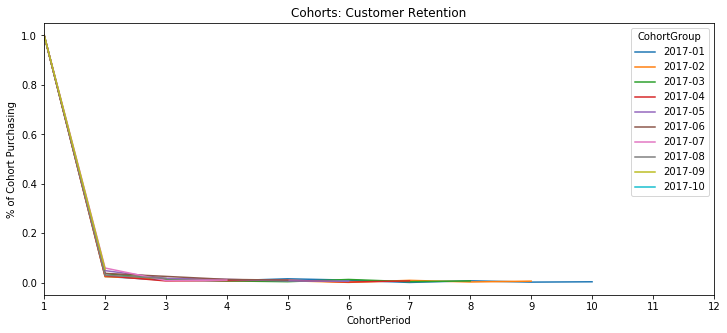

In [18]:
user_retention[['2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07','2017-08','2017-09','2017-10']].plot(figsize=(12,5))
plt.title('Cohorts: Customer Retention')
plt.xticks(np.arange(1, 12.1, 1))
plt.xlim(1, 12)
plt.ylabel('% of Cohort Purchasing');

#### Seaborn makes it easy for us to plot graphs like the one below. 

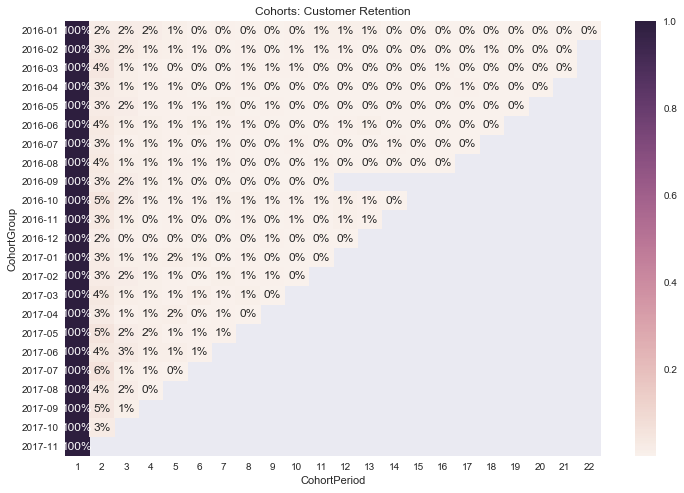

In [60]:
#Seaborn
# http://stanford.edu/~mwaskom/software/seaborn/

import seaborn as sns
sns.set(style='dark')

plt.figure(figsize=(12, 8))
plt.title('Cohorts: Customer Retention')
sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=True, fmt='.0%');

#### We can do the same analysis but this time round, looking at revenue numbers instead

In [61]:
# create a Series holding the total size of each CohortGroup
cohort_revenue_size = cohorts['Revenue'].groupby(level=0).first()
cohort_revenue_size.head()

CohortGroup
2016-01    103846.94
2016-02     88065.95
2016-03     96386.72
2016-04    110155.50
2016-05    126945.67
Name: Revenue, dtype: float64

In [62]:
cohorts['Revenue'].head()

CohortGroup  CohortPeriod
2016-01      1               103846.94
             2                 2060.84
             3                 1773.64
             4                 2062.70
             5                  555.96
Name: Revenue, dtype: float64

In [63]:
customer_cohort_revenue = cohorts['Revenue'].unstack(0)
customer_cohort_revenue.head()

CohortGroup,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,...,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11
CohortPeriod,,,,,,,,,,,,,,,,,,,,,
1,103846.94,88065.95,96386.72,110155.50,126945.67,92153.59,89527.13,97264.53,87261.60,98112.94,...,76841.23,112946.62,84574.91,112789.42,94346.99,84449.61,98659.00,85624.50,131155.41,54612.82
2,2060.84,3968.55,5746.35,4140.42,3229.66,5222.91,2222.98,6780.67,1992.05,7682.74,...,3512.39,3459.54,2499.43,11360.53,7436.17,4775.92,5032.40,3405.54,4408.43,NaN
3,1773.64,2207.58,788.48,1040.85,8843.48,1461.71,569.50,3568.83,1192.20,1933.67,...,899.59,802.40,286.75,1541.89,2629.28,284.15,3439.23,1180.45,NaN,NaN
4,2062.70,1644.44,906.37,796.66,523.05,1649.80,1562.30,1325.25,702.47,1277.33,...,489.37,817.58,1379.71,2055.26,2202.47,1020.76,218.01,NaN,NaN,NaN
5,555.96,574.15,259.80,569.01,703.04,703.70,802.15,1118.31,393.32,1229.25,...,829.52,1973.05,1234.84,998.93,2021.46,84.82,NaN,NaN,NaN,NaN


In [64]:
user_retention_revenue = cohorts['Revenue'].unstack(0).divide(cohort_revenue_size, axis=1)
user_retention_revenue.head()

CohortGroup,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,...,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11
CohortPeriod,,,,,,,,,,,,,,,,,,,,,
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
2,0.019845,0.045063,0.059618,0.037587,0.025441,0.056676,0.024830,0.069714,0.022828,0.078305,...,0.045710,0.030630,0.029553,0.100723,0.078817,0.056553,0.051008,0.039773,0.033612,NaN
3,0.017079,0.025067,0.008180,0.009449,0.069664,0.015862,0.006361,0.036692,0.013662,0.019709,...,0.011707,0.007104,0.003390,0.013671,0.027868,0.003365,0.034860,0.013786,NaN,NaN
4,0.019863,0.018673,0.009403,0.007232,0.004120,0.017903,0.017451,0.013625,0.008050,0.013019,...,0.006369,0.007239,0.016313,0.018222,0.023344,0.012087,0.002210,NaN,NaN,NaN
5,0.005354,0.006520,0.002695,0.005166,0.005538,0.007636,0.008960,0.011498,0.004507,0.012529,...,0.010795,0.017469,0.014601,0.008857,0.021426,0.001004,NaN,NaN,NaN,NaN


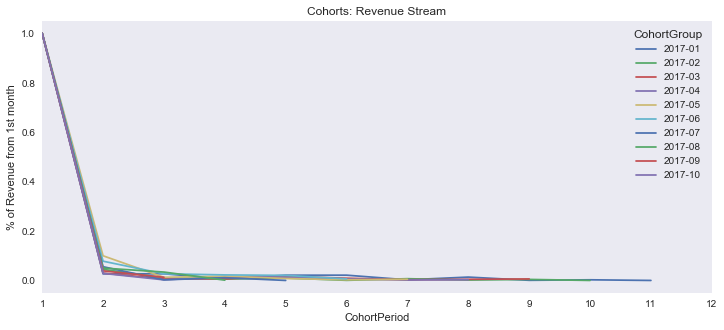

In [65]:
user_retention_revenue[['2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07','2017-08','2017-09','2017-10']].plot(figsize=(12,5))
plt.title('Cohorts: Revenue Stream')
plt.xticks(np.arange(1, 12.1, 1))
plt.xlim(1, 12)
plt.ylabel('% of Revenue from 1st month');

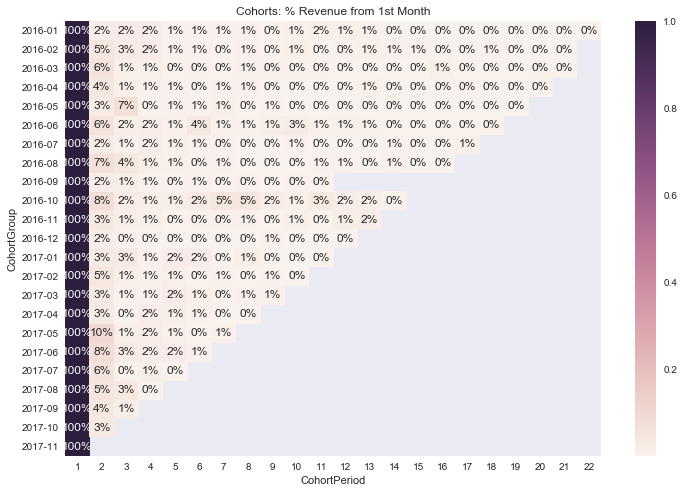

In [66]:
import seaborn as sns
sns.set(style='darkgrid')

plt.figure(figsize=(12, 8))
plt.title('Cohorts: % Revenue from 1st Month')
sns.heatmap(user_retention_revenue.T, mask=user_retention_revenue.T.isnull(), annot=True, fmt='.0%');

#### Finally we export these graphs to a csv file for reporting purposes

In [67]:
#export tables to CSV
user_retention.to_csv(path_or_buf='retention.csv',sep=',')
customer_cohort.to_csv(path_or_buf='customer_cohort.csv',sep=',')
user_retention_revenue.to_csv(path_or_buf='retention_revenue.csv',sep=',')
customer_cohort_revenue.to_csv(path_or_buf='customer_cohort_revenue.csv',sep=',')